In [1]:
%load_ext autotime
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
import cv2
import matplotlib.pyplot as plt # Plotting
plt.rcParams['figure.figsize'] = [10, 10]
import numpy as np # Numeric data
import pandas as pd # Tabular data
from rasterio.features import shapes # Vectorising rasters to polygons
from shapely import Point, LineString, Polygon # Geometry
from shapely.geometry import box, shape
from shapely.ops import nearest_points
import geopandas as gpd # Plotting polygons
from tqdm.auto import tqdm # Progress bars
tqdm.pandas()

In [2]:
checkpoint = 'sam_vit_h_4b8939.pth'
sam = sam_model_registry['vit_h'](checkpoint=checkpoint)
# SAM takes 1 min 18 s on a CPU and 15.6s on a P40 GPU, so best to use a GPU
device = 'cuda:0'
sam.to(device)
print("SAM loaded")

SAM loaded


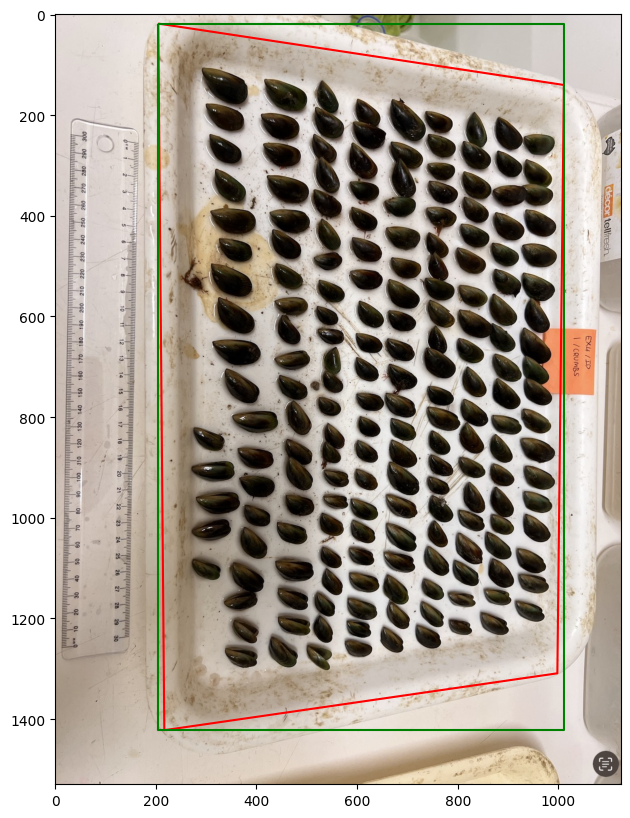

[[ 7.56422957e-01 -1.12537290e-02  4.17070647e+01]
 [-1.43934636e-01  9.26897768e-01  3.00823512e+01]
 [-1.98664309e-04 -2.16609195e-05  1.00000000e+00]]


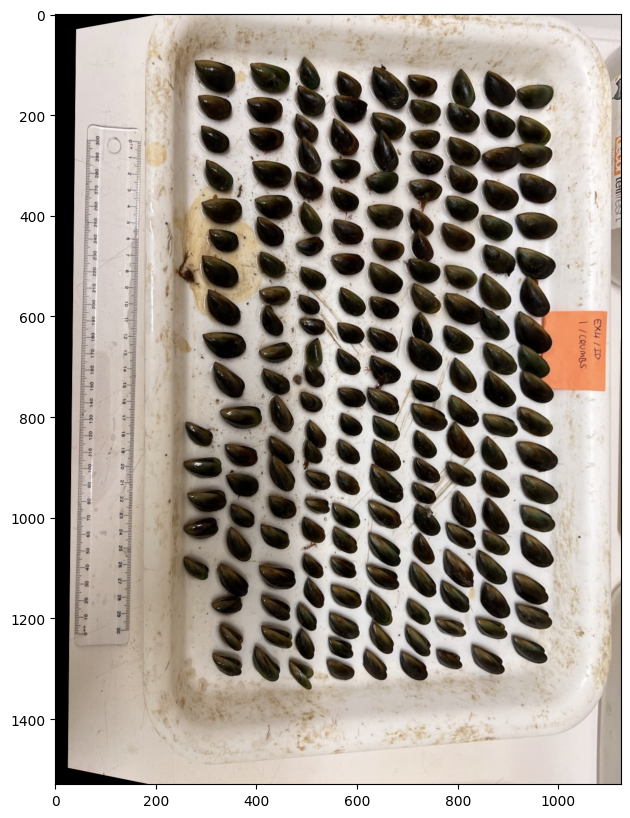

In [3]:
# Reproject trapezoidal tray to rectangular (rectify)
def snap(g1, g2, threshold=1e6):
    coordinates = []
    for x, y in g1.coords:  # for each vertex in the first line
        point = Point(x, y)
        p1, p2 = nearest_points(point, g2)  # find the nearest point on the second line
        if p1.distance(p2) <= threshold:
            # it's within the snapping tolerance, use the snapped vertex
            coordinates.append(p2.coords[0])
        else:
            # it's too far, use the original vertex
            coordinates.append((x, y))
    # convert coordinates back to a LineString and return
    return LineString(coordinates)

img = cv2.cvtColor(cv2.imread('test2.png'), cv2.COLOR_BGR2RGB)
masks = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32, # The number of points to be sampled along one side of the image
    min_mask_region_area=100, # If >0, postprocessing will be applied to remove disconnected regions and holes in masks with area smaller than min_mask_region_area
).generate(img)
tray = max(masks, key=lambda x: x["area"])
# Convert binary mask to polygon
tray = shape(next(shapes(tray["segmentation"].astype(np.uint8), mask=tray["segmentation"]))[0])
plt.imshow(img)
trapezoid = snap(tray.envelope.exterior, tray)
bounds = trapezoid.envelope.exterior
gpd.GeoSeries(trapezoid).plot(ax=plt.gca(), color="red")
gpd.GeoSeries(bounds).plot(ax=plt.gca(), color="green")
plt.show()
source_corners = np.float32(trapezoid.coords[:4])
target_corners = np.float32(bounds.coords[:4])
matrix = cv2.getPerspectiveTransform(source_corners, target_corners)
print(matrix)
img = cv2.warpPerspective(img, matrix, (img.shape[1], img.shape[0]), cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))
plt.imshow(img)

In [4]:
masks = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=50, # The number of points to be sampled along one side of the image
    min_mask_region_area=100, # If >0, postprocessing will be applied to remove disconnected regions and holes in masks with area smaller than min_mask_region_area
).generate(img)
len(masks)

241

In [5]:
masks[0]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 18219,
 'bbox': [967, 590, 128, 158],
 'predicted_iou': 1.0080046653747559,
 'point_coords': [[1045.3200000000002, 719.1]],
 'stability_score': 0.9864695072174072,
 'crop_box': [0, 0, 1124, 1530]}

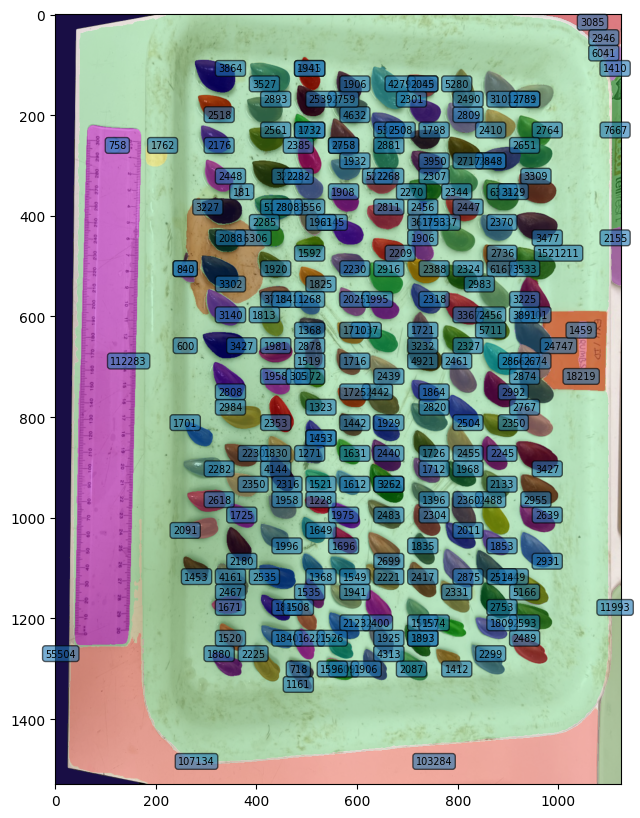

In [6]:
def show_anns(anns, alpha=.5):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [alpha]])
        img[m] = color_mask
        x, y = ann["point_coords"][0]
        plt.text(s=ann["area"], x=x, y=y, ha='center', va='center', bbox=dict(boxstyle="round", alpha=.6), fontsize="x-small")
    ax.imshow(img)

plt.imshow(img)
show_anns(masks)

In [7]:
masks = sorted(masks, key=(lambda x: x['area']), reverse=True)
full_mask = np.zeros_like(masks[0]["segmentation"]).astype(int)
for i in range(len(masks)):
   x, y = np.where(masks[i]['segmentation'])
   full_mask[x,y] = i + 1

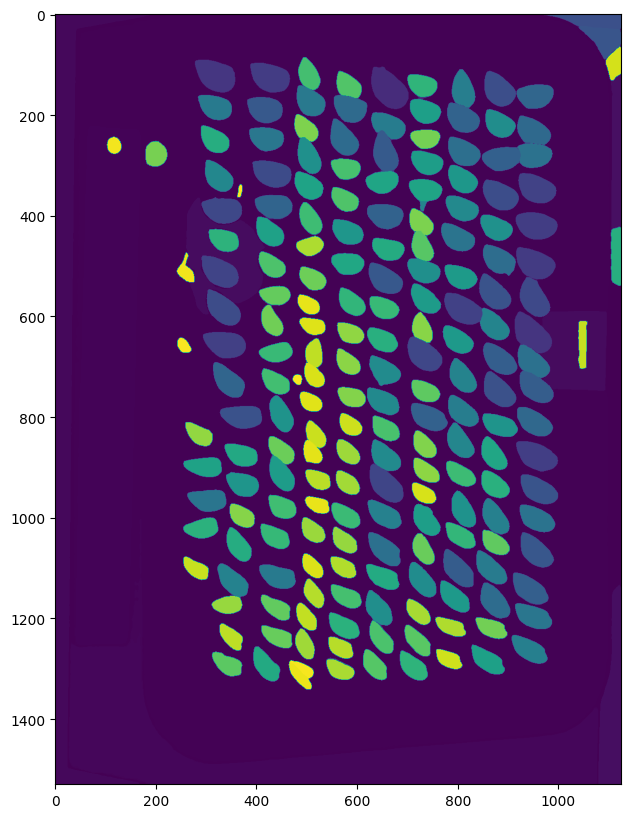

In [8]:
plt.imshow(full_mask)

In [9]:
# Vectorise raster
shape_gen = ((shape(s), v) for s, v in shapes(full_mask.astype(np.uint8), mask=full_mask>0))
# Convert shapes to GeoDataFrame, taking CRS from the image
df = gpd.GeoDataFrame(dict(zip(["geometry", "id"], zip(*shape_gen))))
df

geometry    id
0     POLYGON ((969.000 0.000, 969.000 2.000, 971.00...  14.0
1     POLYGON ((989.000 5.000, 989.000 6.000, 993.00...  14.0
2     POLYGON ((994.000 6.000, 994.000 7.000, 998.00...  14.0
3     POLYGON ((999.000 7.000, 999.000 8.000, 1002.0...  14.0
4     POLYGON ((1003.000 8.000, 1003.000 9.000, 1004...  14.0
...                                                 ...   ...
1516  POLYGON ((0.000 0.000, 0.000 1530.000, 167.000...   5.0
1517  POLYGON ((167.000 1230.000, 170.000 1230.000, ...   4.0
1518  POLYGON ((1120.000 1134.000, 1122.000 1134.000...   9.0
1519  POLYGON ((1076.000 1495.000, 1076.000 1527.000...   3.0
1520  POLYGON ((95.000 1508.000, 95.000 1509.000, 98...   3.0

[1521 rows x 2 columns]

<Axes: >

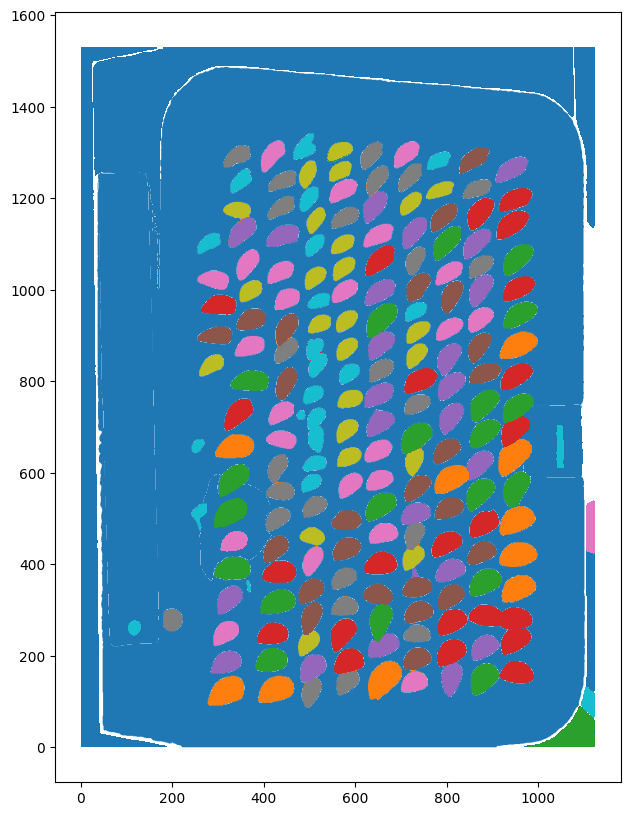

In [10]:
df.plot(column="id", categorical=True)

In [11]:
df["area"] = df.area

<Axes: >

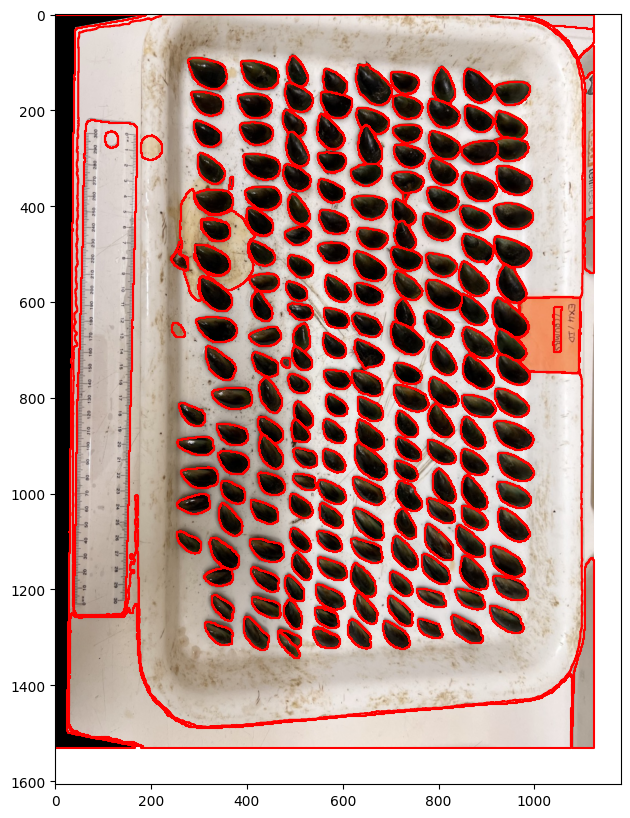

In [12]:
plt.imshow(img)
df.boundary.plot(color="red", ax=plt.gca())

In [13]:
df = df.sort_values(by="area", ascending=False)
df

geometry    id      area
1503  POLYGON ((221.000 0.000, 909.000 0.000, 909.00...   1.0  914991.0
1294  POLYGON ((72.000 221.000, 83.000 221.000, 83.0...   2.0  111525.0
1517  POLYGON ((167.000 1230.000, 170.000 1230.000, ...   4.0  103284.0
1516  POLYGON ((0.000 0.000, 0.000 1530.000, 167.000...   5.0   55504.0
954   POLYGON ((1030.000 590.000, 1081.000 590.000, ...   7.0   16760.0
...                                                 ...   ...       ...
727   POLYGON ((421.000 543.000, 421.000 544.000, 42...  39.0       1.0
728   POLYGON ((460.000 544.000, 460.000 545.000, 46...  39.0       1.0
729   POLYGON ((925.000 544.000, 925.000 545.000, 92...  11.0       1.0
730   POLYGON ((304.000 547.000, 304.000 548.000, 30...   1.0       1.0
864   POLYGON ((984.000 662.000, 984.000 663.000, 98...   6.0       1.0

[1521 rows x 3 columns]

<Axes: >

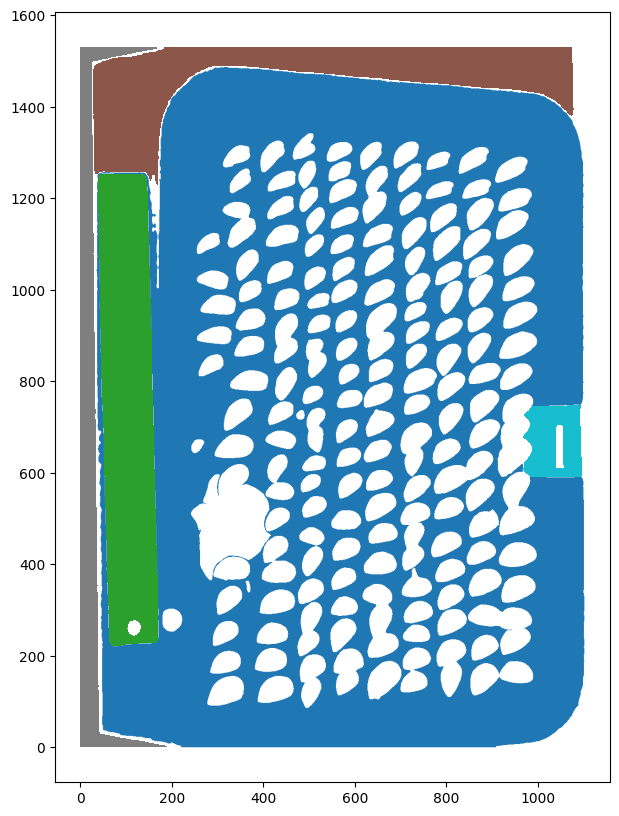

In [14]:
df.head(5).plot(column="id", categorical=True)

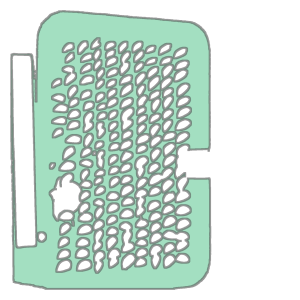

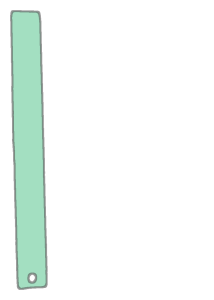

In [15]:
# Tray is largest, then the desk, then the ruler
tray = df.iloc[0]
display(tray.geometry)
# The ruler will be one of the top largest objects by area, and it's aspect ratio will be low (width much less than height)
def find_ruler(df):
  for i, row in df.iterrows():
    x1, y1, x2, y2 = row.geometry.bounds
    width = x2 - x1
    height = y2 - y1
    ratio = width / height
    if ratio < .15:
      return row

ruler = find_ruler(df)
display(ruler.geometry)

In [16]:
x1, y1, x2, y2 = ruler.geometry.bounds
ruler_height = y2 - y1
# pixels to cm conversion. ruler is 32cm long
px_per_cm = ruler_height / 32
px_per_cm

32.28125

In [17]:
df["centroid"] = df.centroid

In [18]:
df.iloc[0].centroid.coords[0]

(593.3667320225007, 734.2595222248087)

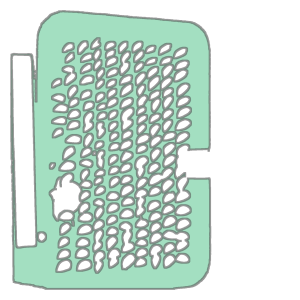

In [19]:
tray.geometry

In [20]:
def get_dimensions(geom):
    x1, y1, x2, y2 = geom.bounds
    width = x2 - x1
    height = y2 - y1
    return width, height

width, height = get_dimensions(tray.geometry)
width, height

(1066.0, 1487.0)

0it [00:00, ?it/s]

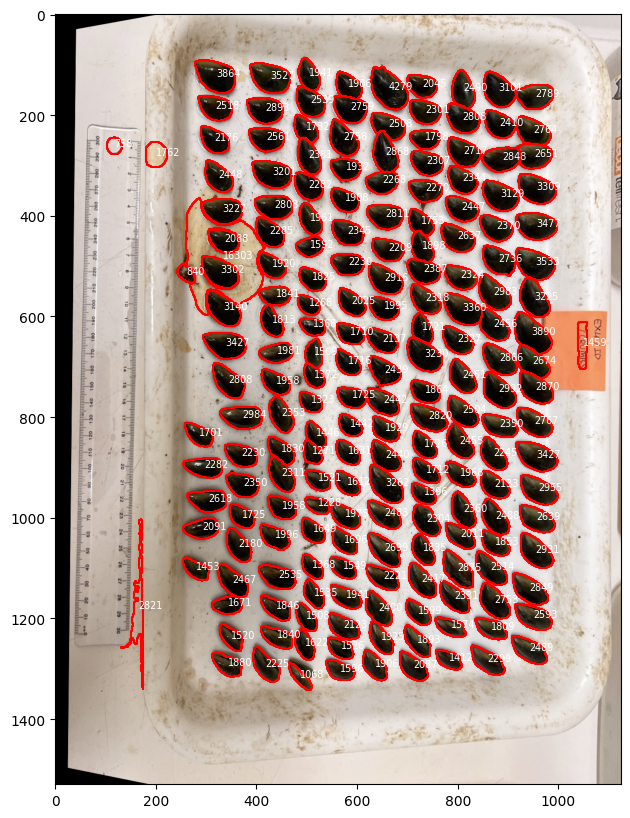

In [21]:
# Filter to just shapes in the tray
tray_edge_buffer = height * .03
area_threshold = height * .5
df = df[df.within(tray.geometry.envelope.buffer(-tray_edge_buffer)) & (df.area > area_threshold)]
plt.imshow(img)
df.boundary.plot(ax=plt.gca(), color="red")
for i, row in tqdm(df.iterrows()):
  plt.annotate(round(row.area), row.centroid.coords[0], color="white", fontsize="x-small")

In [22]:
df

geometry     id     area  \
760   POLYGON ((283.000 365.000, 287.000 365.000, 28...    8.0  16303.0   
177   POLYGON ((649.000 104.000, 650.000 104.000, 65...   31.0   4279.0   
876   POLYGON ((922.000 591.000, 925.000 591.000, 92...   37.0   3890.0   
122   POLYGON ((284.000 91.000, 306.000 91.000, 306....   38.0   3864.0   
695   POLYGON ((922.000 463.000, 926.000 463.000, 92...   42.0   3533.0   
...                                                 ...    ...      ...   
762   POLYGON ((486.000 557.000, 489.000 557.000, 48...  232.0   1268.0   
1070  POLYGON ((503.000 958.000, 507.000 958.000, 50...  233.0   1228.0   
1381  POLYGON ((466.000 1286.000, 467.000 1286.000, ...  234.0   1068.0   
697   POLYGON ((254.000 494.000, 257.000 494.000, 25...  236.0    840.0   
331   POLYGON ((115.000 244.000, 119.000 244.000, 11...  237.0    758.0   

                      centroid  
760    POINT (332.900 483.801)  
177    POINT (662.894 148.580)  
876    POINT (947.061 635.277)  
122    POINT (319.369 122.227)  
695    POINT (953.106 495.917)  
...                        ...  
762    POINT (503.430 577.838)  
1070   POINT (521.680 975.344)  
1381  POINT (486.620 1317.051)  
697    POINT (260.476 515.302)  
331    POINT (117.567 261.270)  

[192 rows x 4 columns]

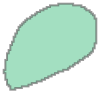

In [23]:
sample = df.sample(1)
poly = sample.geometry.iloc[0]
poly

In [24]:
# Get diameter of polygon by brute force, checking each point pair
def get_diameter(poly):
    max_dist = 0
    coords = [Point(x,y) for x,y in poly.exterior.coords]
    result_coords = []
    for i, a in enumerate(coords):
        for j, b in enumerate(coords):
            if i < j:
                dist = a.distance(b)
                if dist > max_dist:
                    max_dist = dist
                    result_coords = [a, b]

    line = LineString(result_coords)
    return line

line = get_diameter(poly)
line, line.length

(<LINESTRING (414 704, 465 749)>, 68.01470429252781)

Text(439.5, 726.5, '68.01px')

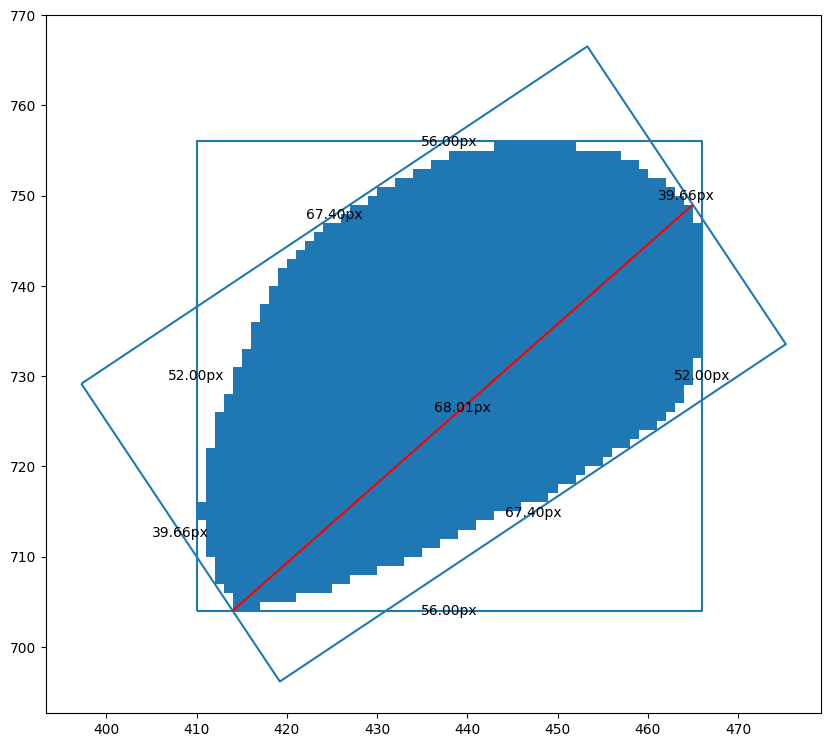

In [25]:
def get_dist(a, b):
    return Point(a).distance(Point(b))

def midpoint(a, b):
    return ((a[0]+b[0])/2, (a[1]+b[1])/2)

def annotate_dist(poly):
    coords = list(poly.exterior.coords)
    for i in range(len(coords)-1):
        a, b = coords[i], coords[i+1]
        dist = get_dist(a, b)
        plt.annotate(f"{dist:.2f}px", xy=midpoint(a, b), ha='center', va='center')

mrr = poly.minimum_rotated_rectangle
bbox = poly.envelope
line = get_diameter(poly)

ax = gpd.GeoSeries([poly, mrr.exterior, bbox.exterior]).plot()
gpd.GeoSeries(line).plot(color="red", ax=ax)
annotate_dist(bbox)
annotate_dist(mrr)
plt.annotate(f"{line.length:.2f}px", xy=midpoint(*list(line.coords)), ha='center', va='center')

In [26]:
df["diameter_line"] = df.geometry.progress_apply(get_diameter)
df["diameter_line"]

  0%|          | 0/192 [00:00<?, ?it/s]

/mnt/nid_env/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


760       LINESTRING (283.000 365.000, 303.000 597.000)
177       LINESTRING (692.000 184.000, 633.000 105.000)
876       LINESTRING (978.000 670.000, 920.000 592.000)
122        LINESTRING (354.000 146.000, 278.000 94.000)
695       LINESTRING (989.000 514.000, 918.000 465.000)
                             ...                       
762       LINESTRING (525.000 591.000, 484.000 559.000)
1070      LINESTRING (544.000 989.000, 498.000 961.000)
1381    LINESTRING (466.000 1286.000, 508.000 1342.000)
697       LINESTRING (254.000 494.000, 276.000 533.000)
331       LINESTRING (115.000 244.000, 121.000 278.000)
Name: diameter_line, Length: 192, dtype: geometry

In [27]:
ruler.diameter_line = get_diameter(ruler.geometry)

  0%|          | 0/192 [00:00<?, ?it/s]

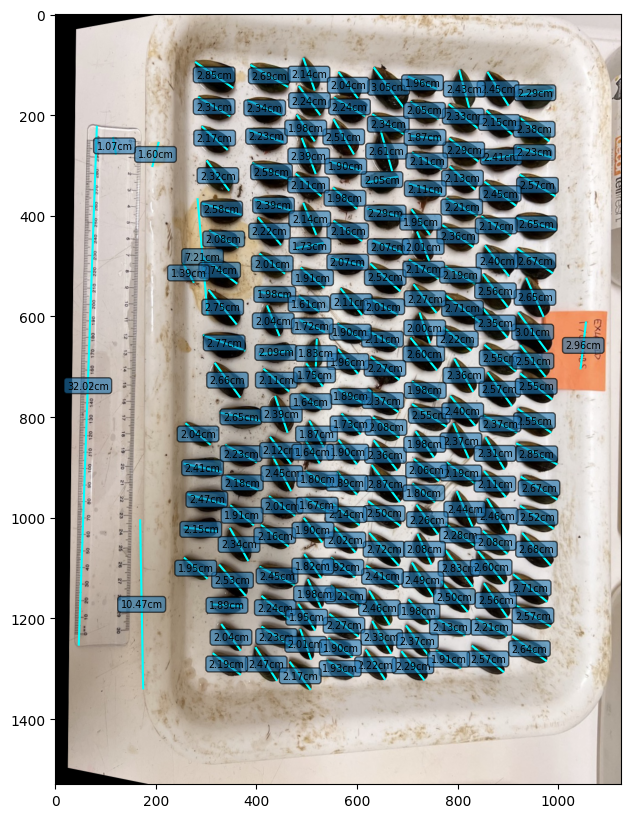

In [28]:
def annotate_length(line):
    x, y = midpoint(*list(line.coords))
    plt.text(s=f"{line.length/px_per_cm:.2f}cm", x=x, y=y, ha='center', va='center', bbox=dict(boxstyle="round", alpha=.6), fontsize="x-small")

plt.imshow(img)
ax = plt.gca()
gpd.GeoSeries(ruler.diameter_line).plot(color="cyan", ax=ax)
annotate_length(ruler.diameter_line)
df.diameter_line.plot(color="cyan", ax=ax)
for line in tqdm(df.diameter_line):
    annotate_length(line)

In [29]:
df["length_cm"] = df.diameter_line.length / px_per_cm
# Discard results longer than 5cm, probably misdetections
df = df[df["length_cm"] < 5]
df.length_cm.describe()

/mnt/nid_env/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


count    190.000000
mean       2.242526
std        0.316308
min        1.069517
25%        2.015871
50%        2.228995
75%        2.459757
max        3.054411
Name: length_cm, dtype: float64